## Model Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [4]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [5]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [6]:
price_logs = np.log1p(df.msrp)

<Axes: xlabel='msrp', ylabel='Count'>

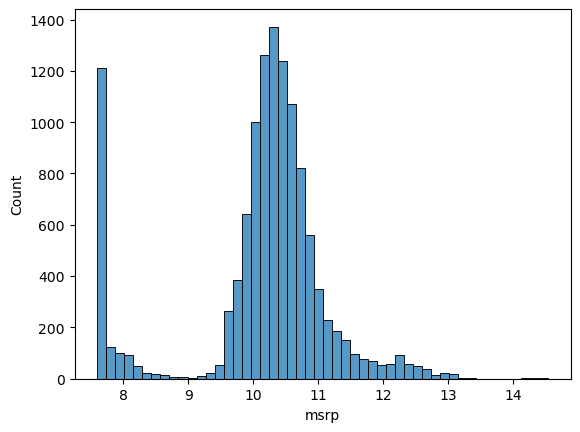

In [7]:
sns.histplot(price_logs, bins = 50)

In [8]:
n = len(df)
n_val = int(len(df)*0.2)  #20% 
n_test = int(len(df)*0.2)  #20% 
n_train = n - n_val - n_test  #60% 

In [10]:
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

In [11]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_val + n_train:]]

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

In [14]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [15]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [16]:
categorical_variables = [
    'make', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 
    'market_category', 'vehicle_size', 'vehicle_style'
]

In [17]:
categories = {}

for c in categorical_variables:
    categories[c] = list(df_train[c].value_counts().head(7).index)
    

In [23]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
 
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df.year
    features = base + ['age']

    for v in [2,3,4]:
        df['num_doors_%s' % v] = (df.number_of_doors == v).astype('int')
        features.append('num_doors_%s' % v)
    
    for c, values in categories.items():
        for v in values:
            df['%s_%s' % (c,v)] = (df[c] == v).astype('int')
            features.append('%s_%s' % (c,v))
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    
    return X

In [24]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
     
    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
     
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
     
    return w_full[0], w_full[1:]

In [32]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [33]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [34]:
X_full_train = prepare_X(df_full_train)
X_full_train

array([[148.,   4.,  33., ...,   0.,   0.,   0.],
       [132.,   4.,  32., ...,   1.,   0.,   0.],
       [148.,   4.,  37., ...,   1.,   0.,   0.],
       ...,
       [332.,   8.,  23., ...,   0.,   0.,   0.],
       [148.,   4.,  34., ...,   0.,   0.,   0.],
       [290.,   6.,  25., ...,   0.,   0.,   0.]])

In [35]:
y_full_train = np.concatenate([y_train, y_val])

In [36]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r = 10)

In [37]:
w0

4.397969894542637

In [38]:
w

array([ 1.77041447e-03,  1.49443399e-01, -5.99379980e-04,  5.79870948e-03,
       -2.55682037e-05, -9.20201602e-02,  1.02544979e+00,  9.59654347e-01,
        1.26627198e+00, -7.87352600e-02,  4.32603493e-02,  2.06600578e-02,
       -1.57815109e-01, -1.31587615e-01, -2.66769116e-01, -2.21487769e-02,
        1.49284094e-01,  6.51089102e-01,  3.19494019e-01,  3.60433036e-02,
        3.65354964e-01,  1.03914529e+00,  4.16364733e-01,  1.07625838e+00,
        9.04615146e-01,  1.07302047e+00,  1.03242167e+00,  3.11654226e-01,
        1.09624268e+00,  1.05957853e+00,  1.13071122e+00,  1.11143747e+00,
       -8.97582826e-02,  9.31704252e-02, -9.79671407e-02, -3.05187084e-02,
       -6.91922850e-02, -8.29873550e-02, -1.06813767e-01,  1.56087365e+00,
        1.42751455e+00,  1.40958169e+00, -1.13949660e-01,  1.98255980e-02,
        1.83439469e-01,  3.41128149e-01, -2.66129014e-01, -1.16027951e-01,
       -1.39619408e-01])

In [39]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
 
score = rmse(y_test, y_pred)
score

0.4554142356792657

<Axes: ylabel='Count'>

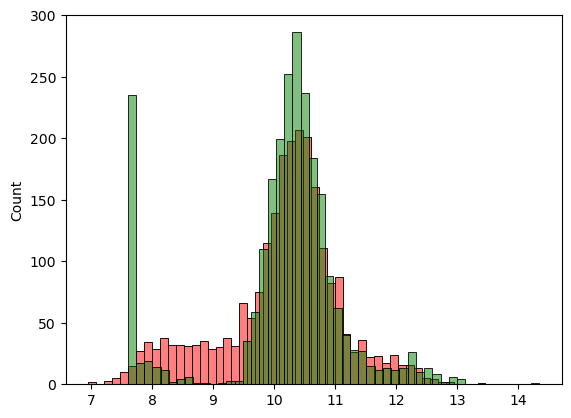

In [40]:
sns.histplot(y_pred, color = 'red',alpha = 0.5, bins=50)
sns.histplot(y_test, color = 'green',alpha = 0.5, bins = 50)

## Testing

In [41]:
car = df_test.iloc[20].to_dict()
df_small = pd.DataFrame([car])
df_small

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,toyota,sienna,2015,regular_unleaded,266.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,25,18,2031


In [42]:
X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

10.45880718098378

In [43]:
np.expm1(y_pred)

34848.95695313615

In [44]:
np.expm1(y_test[20])

35000.00000000001